<h1 style="text-align: center;">CS 6476 - Computer Vision </h1>
<h2 style="text-align: center;">Problem Set 4 - Harris, SIFT, RANSAC</h2>

In [64]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy as cp
import random
SIFT = cv2.xfeatures2d.SIFT_create()


### Part 1 : Harris Corners

In [3]:

def gradients(img):
    im = cv2.GaussianBlur(img,(3,3),2)
    kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    kernelx = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    edges_x = cv2.filter2D(im,cv2.CV_64F,kernelx)
    edges_y = cv2.filter2D(im,cv2.CV_64F,kernely)
    return (edges_x,edges_y)


In [4]:


simA = cv2.imread('simA.jpg',0)
transA = cv2.imread('transA.jpg',0)

simAcp = cp.deepcopy(simA)
transAcp = cp.deepcopy(transA)

kernelxsimA,kernelysimA = gradients(simAcp)
kernelxtransA,kernelytransA = gradients(transAcp)



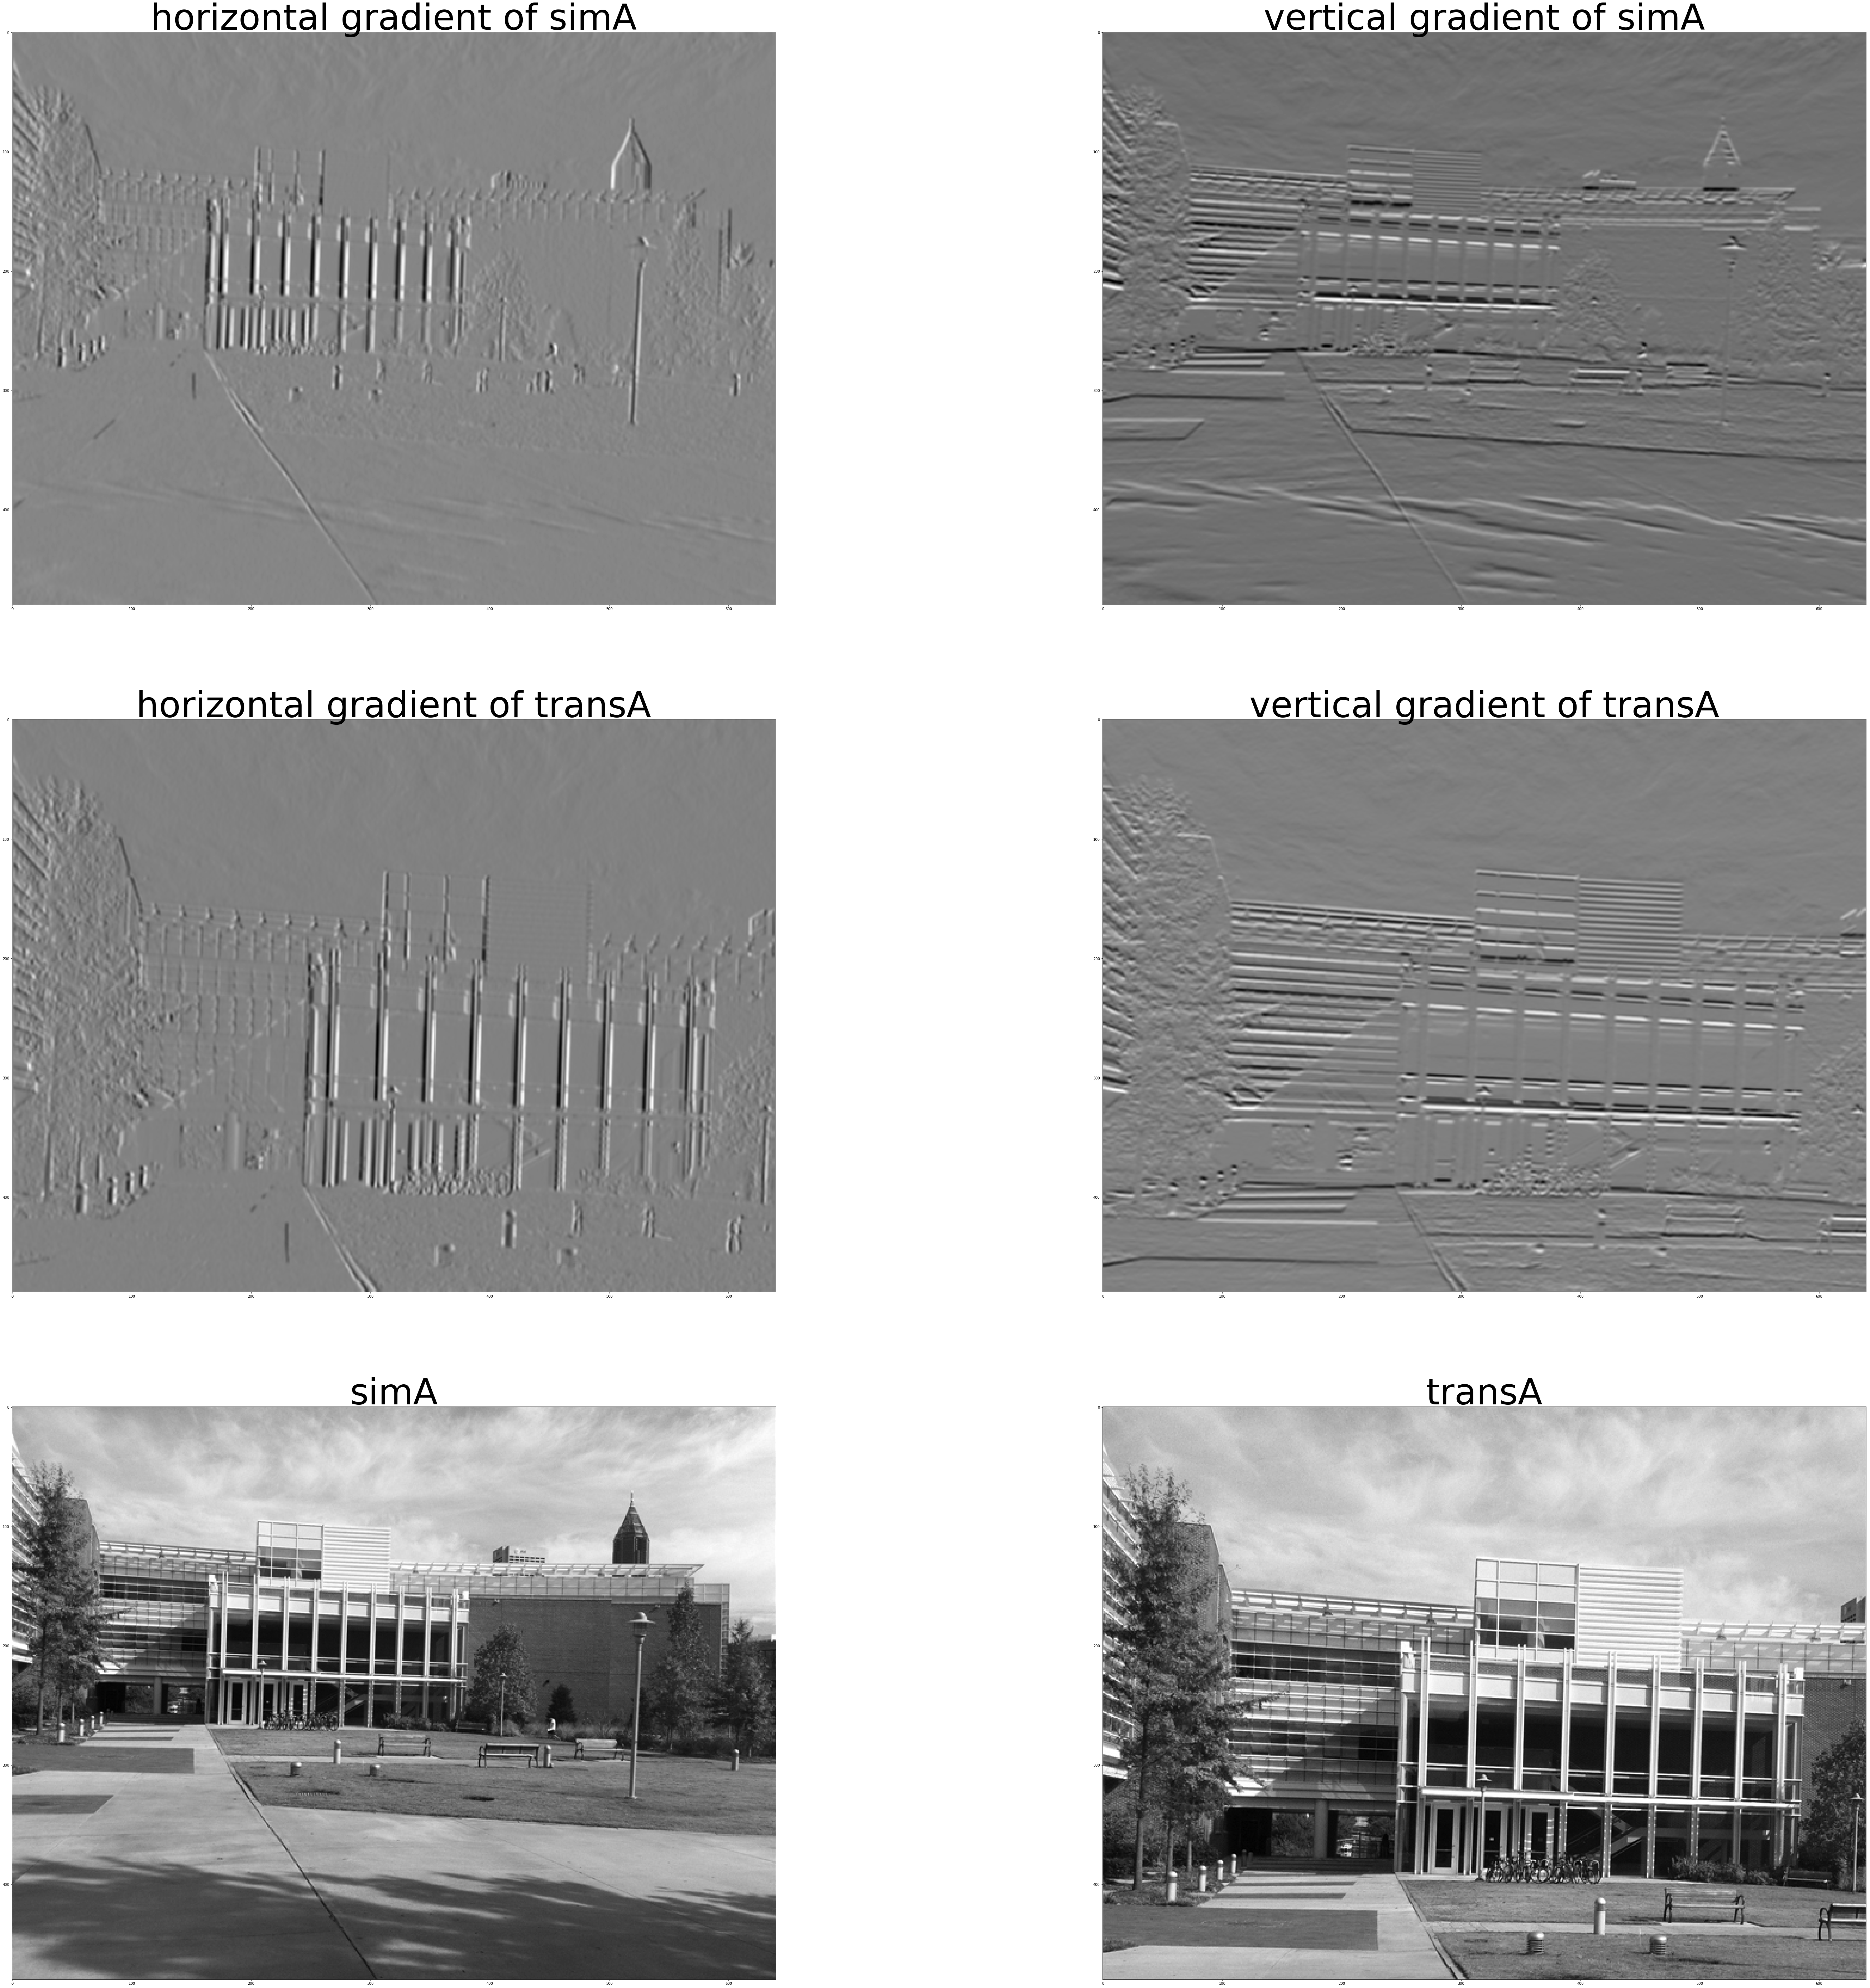

In [5]:
plt.figure(figsize=(100,100))
plt.subplot(3,2,1),plt.imshow(kernelxsimA,cmap='gray'),plt.title('horizontal gradient of simA',fontsize=100)
plt.subplot(3,2,2),plt.imshow(kernelysimA,cmap='gray'),plt.title('vertical gradient of simA',fontsize=100)
plt.subplot(3,2,3),plt.imshow(kernelxtransA,cmap='gray'),plt.title('horizontal gradient of transA',fontsize=100)
plt.subplot(3,2,4),plt.imshow(kernelytransA,cmap='gray'),plt.title('vertical gradient of transA',fontsize=100)
plt.subplot(3,2,5),plt.imshow(simA,cmap='gray'),plt.title('simA',fontsize=100)
plt.subplot(3,2,6),plt.imshow(transA,cmap='gray'),plt.title('transA',fontsize=100)

plt.show()

In [6]:
def harrisValues(Ix,Iy,w_size=5,alpha=0.03):
    Ixy = Ix*Iy
    Ixx = Ix**2
    Iyy = Iy**2
    c = np.zeros((w_size,w_size), dtype=np.float32);
    c[w_size // 2, w_size // 2] = 1.0
    w = cv2.GaussianBlur(c, (w_size,w_size), 0)
    R = np.zeros(Ix.shape).astype(np.float)
    for i in np.arange(w_size//2,Ix.shape[0]-w_size//2):
        for j in np.arange(w_size//2,Ix.shape[1]-w_size//2):     
            mini = i-w_size//2
            maxi = i+w_size//2+1
            minj = j-w_size//2
            maxj = j+w_size//2+1
            Mxy = (w*Ixy[mini:maxi,minj:maxj]).sum()
            M = np.array([[(w*Ixx[mini:maxi,minj:maxj]).sum(),Mxy],[Mxy,(w*Iyy[mini:maxi,minj:maxj]).sum()]])
            R[i,j] = np.linalg.det(M)-alpha*np.square(np.trace(M))
    return R

def norm(im):
    return cv2.normalize(im, im, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def harris(img):
    im = cp.deepcopy(img)
    Ix,Iy = gradients(im)
    R = harrisValues(Ix,Iy)

    return R

In [7]:
simB = cv2.imread('simB.jpg',0)
transB = cv2.imread('transB.jpg',0)

RsimA = harris(simA)

RtransA = harris(transA)

RsimB = harris(simB)

RtransB = harris(transB)


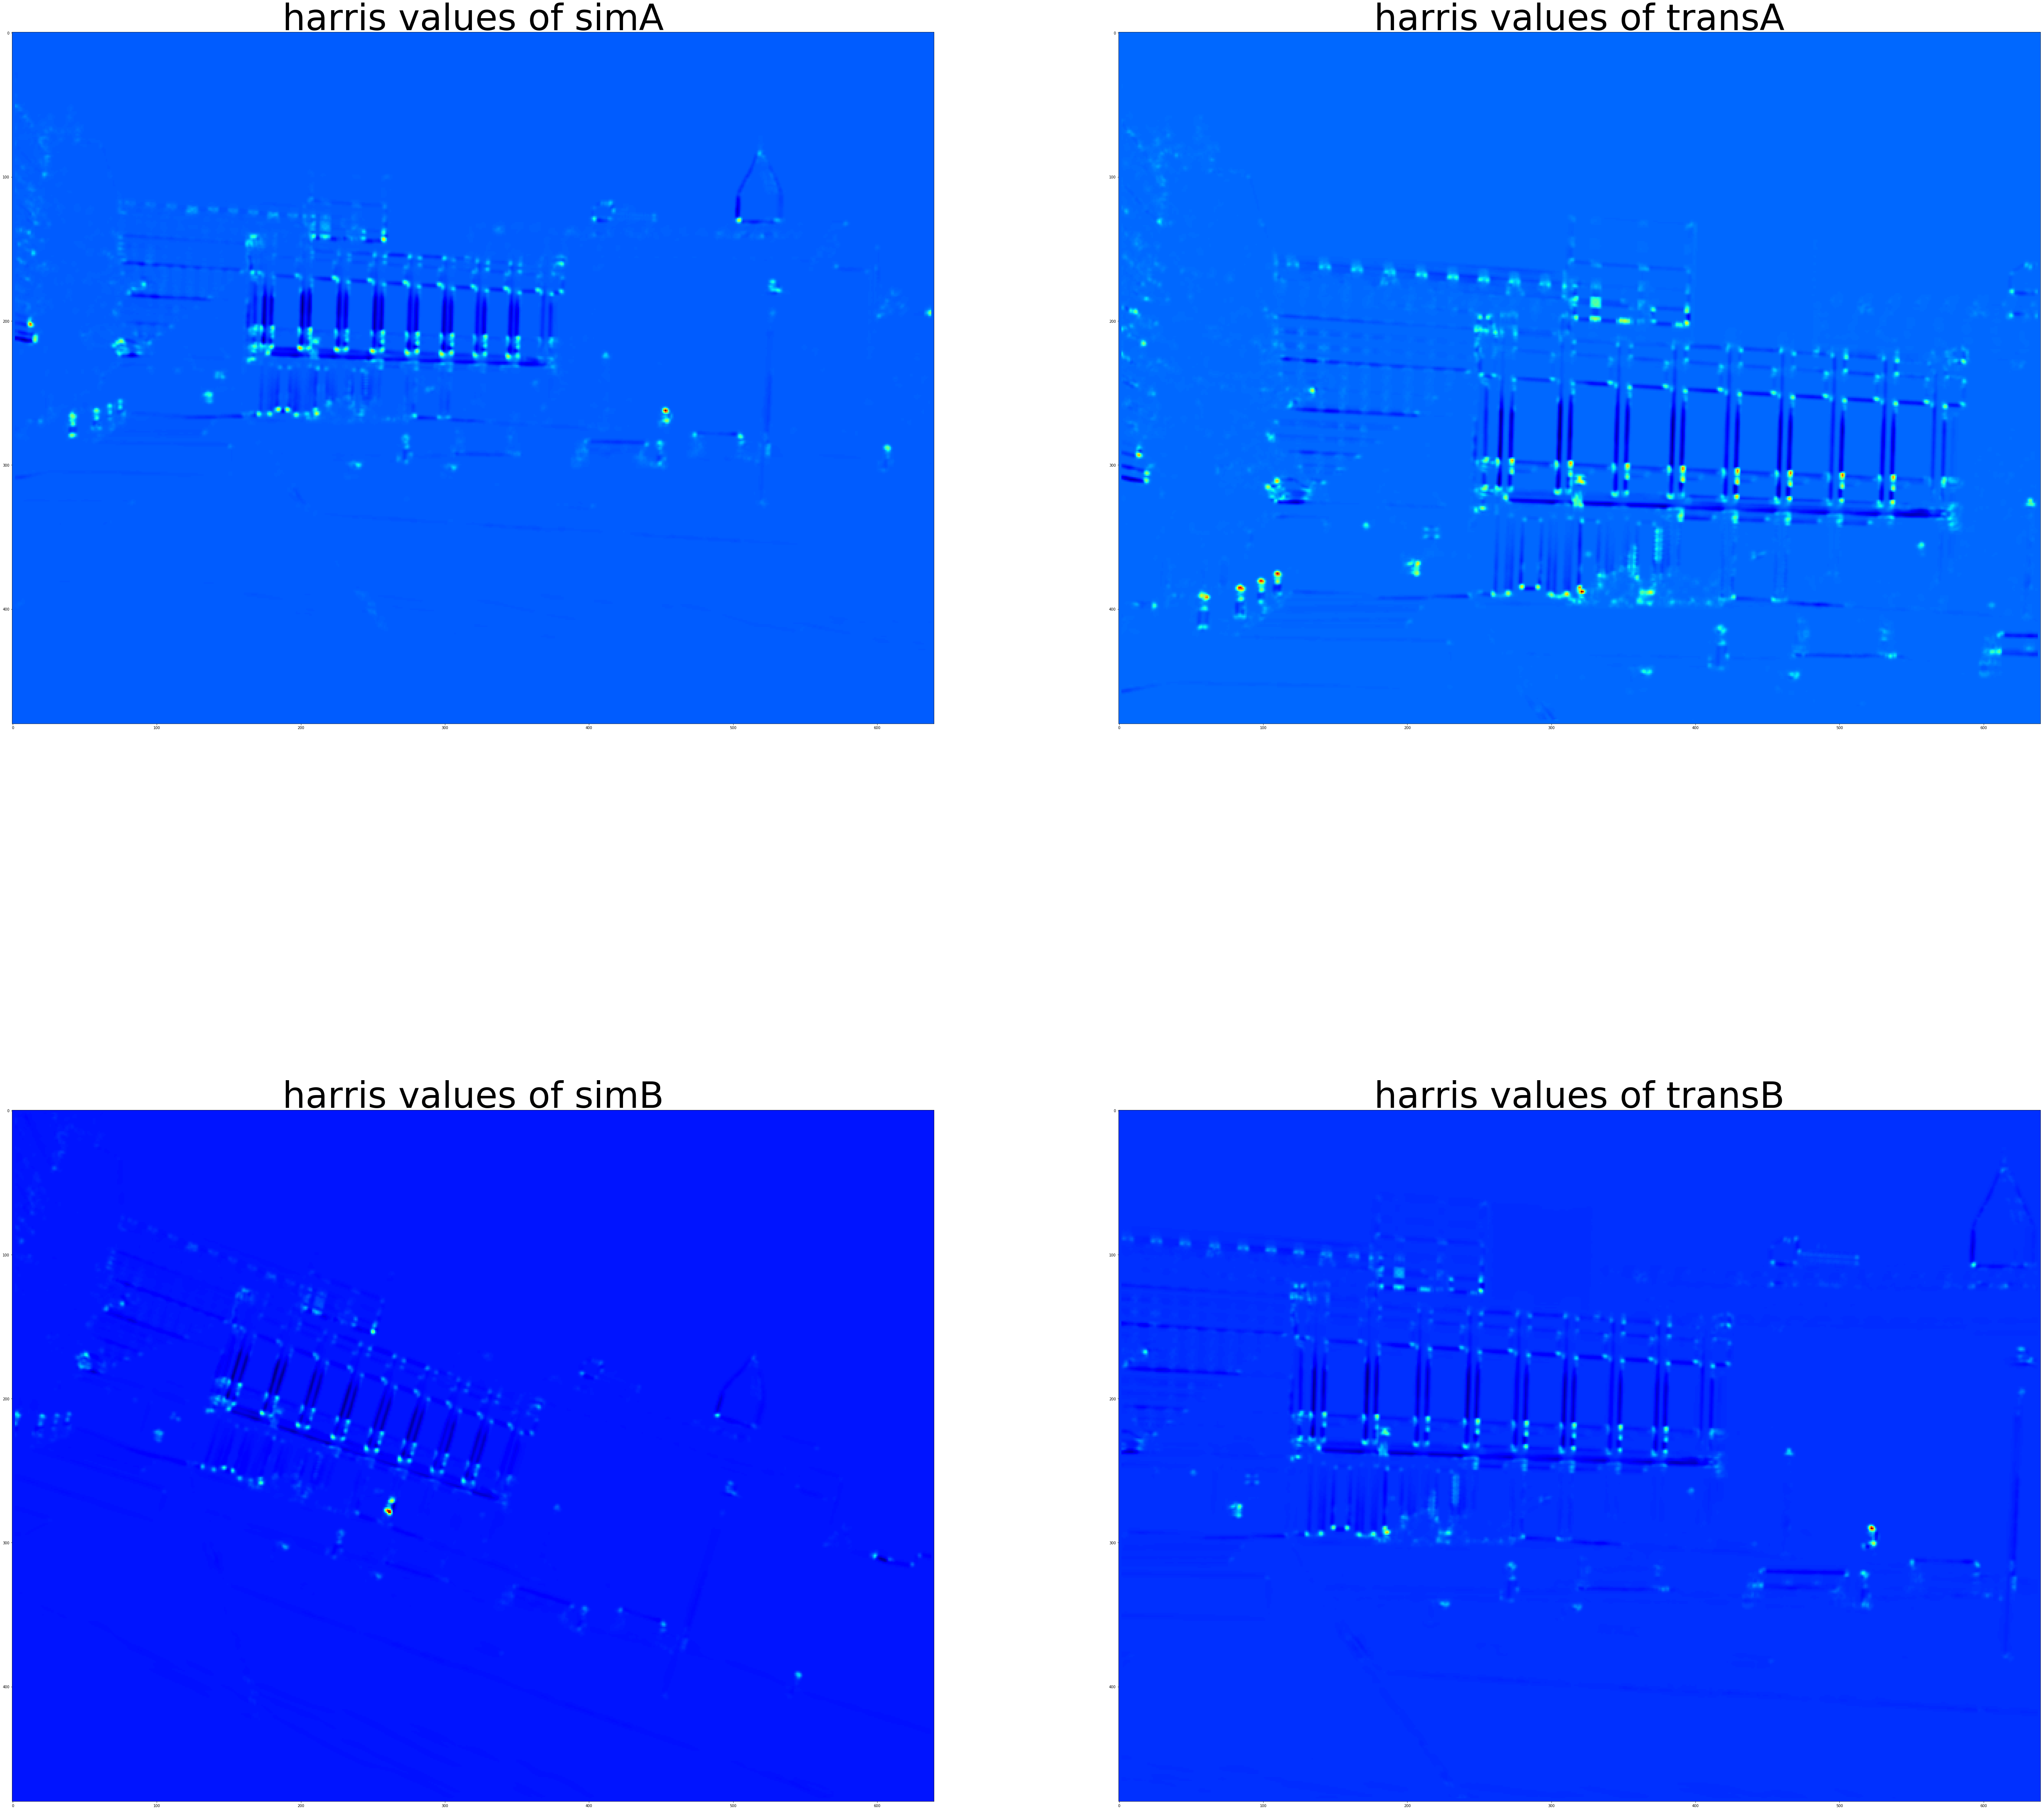

In [8]:
plt.figure(figsize=(100,100))
plt.subplot(2,2,1),plt.imshow(norm(RsimA),cmap='jet'),plt.title('harris values of simA',fontsize=100)
plt.subplot(2,2,2),plt.imshow(norm(RtransA),cmap='jet'),plt.title('harris values of transA',fontsize=100)
plt.subplot(2,2,3),plt.imshow(norm(RsimB),cmap='jet'),plt.title('harris values of simB',fontsize=100)
plt.subplot(2,2,4),plt.imshow(norm(RtransB),cmap='jet'),plt.title('harris values of transB',fontsize=100)

plt.show()

In [101]:
def NMS(R,threshold,radius):
    Rbis = cp.deepcopy(R)
    maxr = np.amax(Rbis)
    threshold = threshold * maxr
    lPotential = []
    lCorners = []
    for i in np.arange(R.shape[0]):
        for j in np.arange(R.shape[1]):
            if( Rbis[i,j]<threshold):
                 Rbis[i,j] = 0
            else:
                lPotential.append((i,j))
        
    for pt in lPotential:
        i = pt[0]
        j = pt[1]
        mini = max(i-radius,0)
        maxi = min(Rbis.shape[0]-1,i+radius)
        minj = max(j-radius,0)
        maxj = min(Rbis.shape[1]-1,j+radius)
            
        if(Rbis[i,j]==Rbis[mini:maxi,minj:maxj].max()):
            lCorners.append((i,j))
            r = Rbis[i,j]
            Rbis[mini:maxi,minj:maxj] = 0
            Rbis[i,j] = r
    return lCorners

def harrisImp(img,threshold=0.1,radius=12):
    R = harris(img)
    return NMS(R,threshold,radius)


In [102]:
check = cv2.imread('check.bmp',0)
checkRot = cv2.imread('check_rot.bmp',0)
checkCorners = harrisImp(check)
checkRotCorners = harrisImp(checkRot)
simAcorners = harrisImp(simA)
transAcorners = harrisImp(transA)

simBcorners = harrisImp(simB)
transBcorners = harrisImp(transB)




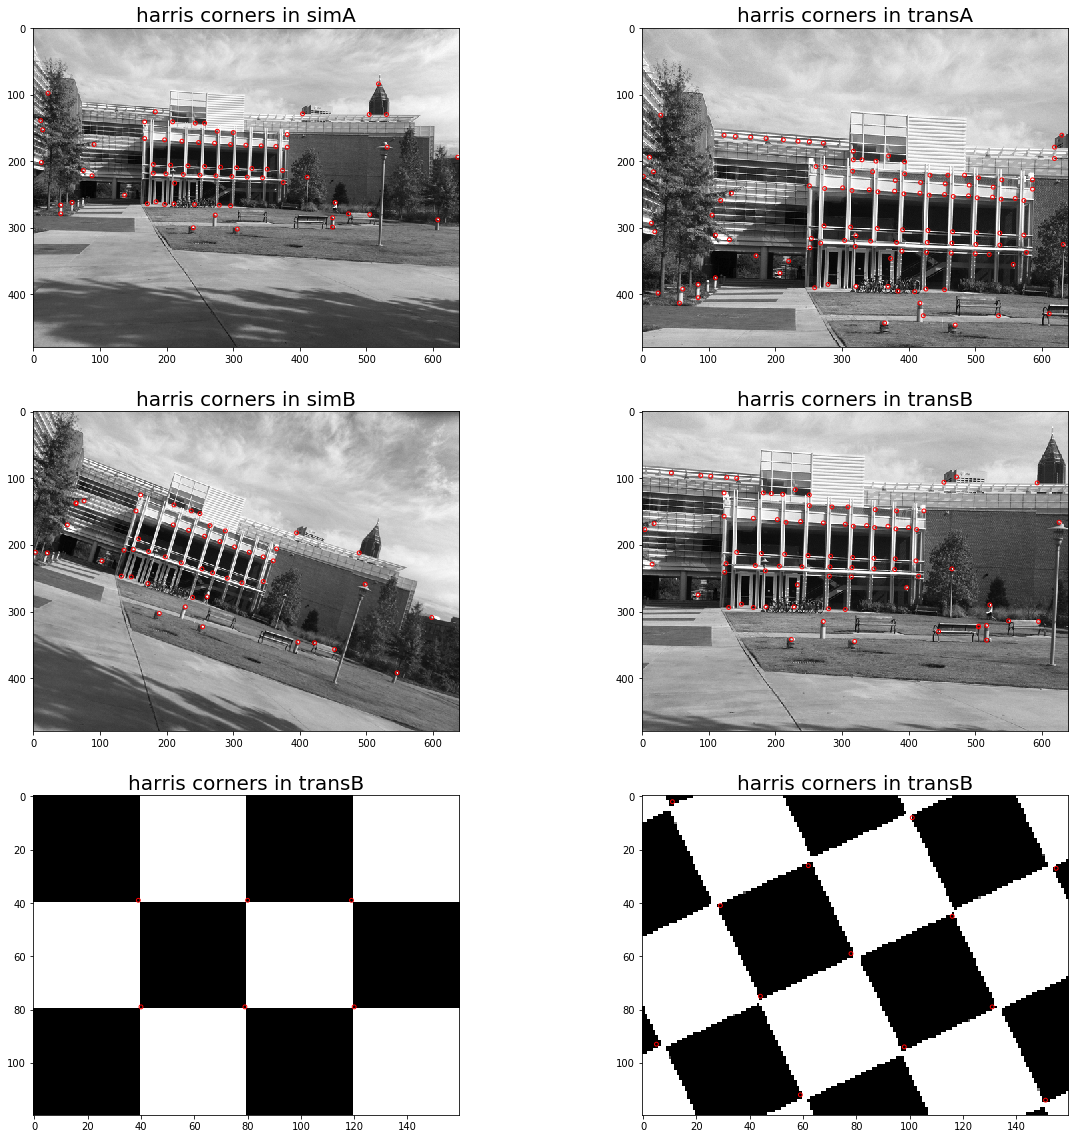

In [103]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1),plt.imshow(simA,cmap='gray'),plt.title('harris corners in simA',fontsize=20),plt.scatter(
    x=[pt[1] for pt in simAcorners], 
    y=[pt[0] for pt in simAcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,2),plt.imshow(transA,cmap='gray'),plt.title('harris corners in transA',fontsize=20),plt.scatter(
    x=[pt[1] for pt in transAcorners], 
    y=[pt[0] for pt in transAcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,3),plt.imshow(simB,cmap='gray'),plt.title('harris corners in simB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in simBcorners], 
    y=[pt[0] for pt in simBcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,4),plt.imshow(transB,cmap='gray'),plt.title('harris corners in transB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in transBcorners], 
    y=[pt[0] for pt in transBcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,5),plt.imshow(check,cmap='gray'),plt.title('harris corners in transB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in checkCorners], 
    y=[pt[0] for pt in checkCorners], 
    s=15, facecolors="none", edgecolors="r"
)

plt.subplot(3,2,6),plt.imshow(checkRot,cmap='gray'),plt.title('harris corners in transB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in checkRotCorners], 
    y=[pt[0] for pt in checkRotCorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.show()


### SIFT features

In [12]:
def features(img):
    keypoints = []
    im = cp.deepcopy(img)
    Ix,Iy = gradients(im)
    O = np.arctan2(Iy,Ix)
    lPoints = harrisImp(im)
    for p in lPoints:
        kpt = cv2.KeyPoint(p[1], p[0], _size=15, _angle=np.deg2rad(O[p[0],p[1]]))
        keypoints.append(kpt)
    im = cv2.drawKeypoints(im,keypoints,im,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return  (keypoints, im)


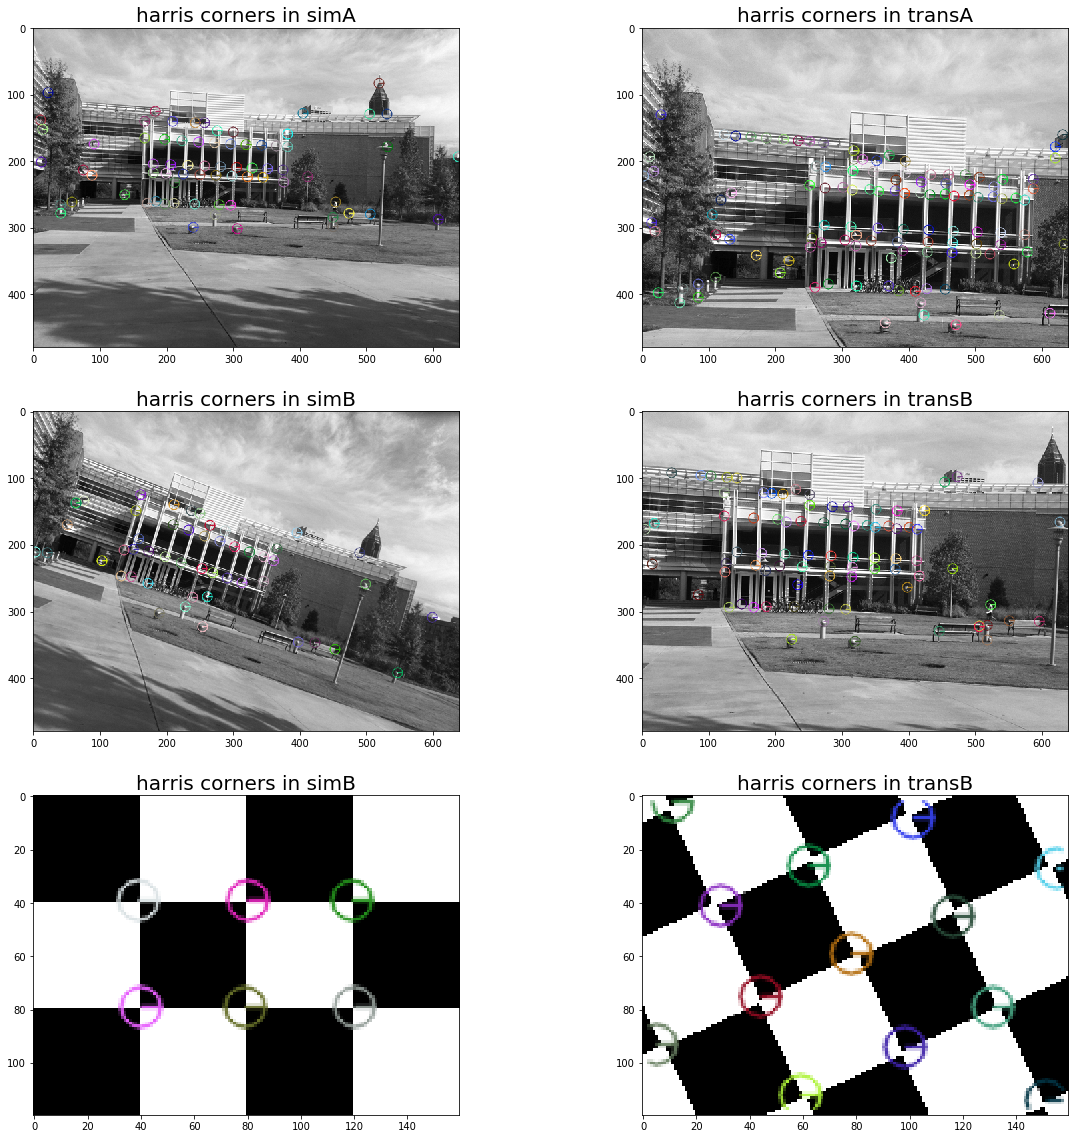

In [104]:
kpSimA,simAsift = features(simA)
kpTransA,transAsift = features(transA)
kpSimB,simBsift = features(simB)
kpTransB,transBsift = features(transB)
kpCheck,checkSift = features(check)
kpCheckRot,checkRotSift = features(checkRot)
# simAsift = cv2.drawKeypoints(simAsift,kpts,simAsift,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,20))
plt.subplot(3,2,1),plt.imshow(simAsift,cmap='gray'),plt.title('harris corners in simA',fontsize=20)
plt.subplot(3,2,2),plt.imshow(transAsift,cmap='gray'),plt.title('harris corners in transA',fontsize=20)
plt.subplot(3,2,3),plt.imshow(simBsift,cmap='gray'),plt.title('harris corners in simB',fontsize=20)
plt.subplot(3,2,4),plt.imshow(transBsift,cmap='gray'),plt.title('harris corners in transB',fontsize=20)
plt.subplot(3,2,5),plt.imshow(checkSift,cmap='gray'),plt.title('harris corners in simB',fontsize=20)
plt.subplot(3,2,6),plt.imshow(checkRotSift,cmap='gray'),plt.title('harris corners in transB',fontsize=20)
plt.show()


In [131]:
def findMatches(img1,img2,kp1,kp2,alpha = 1):
    
    # find the keypoints and descriptors with SIFT
    _, des1 = SIFT.compute(img1,kp1)
    _, des2 = SIFT.compute(img2,kp2)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des2,des1, k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < alpha*n.distance:
            good.append([m])
    
    im = np.zeros((img1.shape[0],img1.shape[1]+img2.shape[1]))
    im[:,:img1.shape[1]]=img1
    im[:,img1.shape[1]:im.shape[1]]=img2
    im = im.astype('uint8')
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    
    for match in good:
        trainId = match[0].trainIdx
        queryId = match[0].queryIdx
        p1 = kp1[trainId].pt
        p2 = kp2[queryId].pt
        y1 = int(p1[1]) 
        x1 = int(p1[0])
        y2 = int(p2[1])
        x2 = int( p2[0]+img1.shape[1])
        color = tuple([random.randint(0,255) for i in range(3)])
        im = cv2.circle(im,(x1,y1),10,color)
        im = cv2.circle(im,(x2,y2),10,color)
        im = cv2.line(im,(x1,y1),(x2,y2),color,2)       
    return im,good


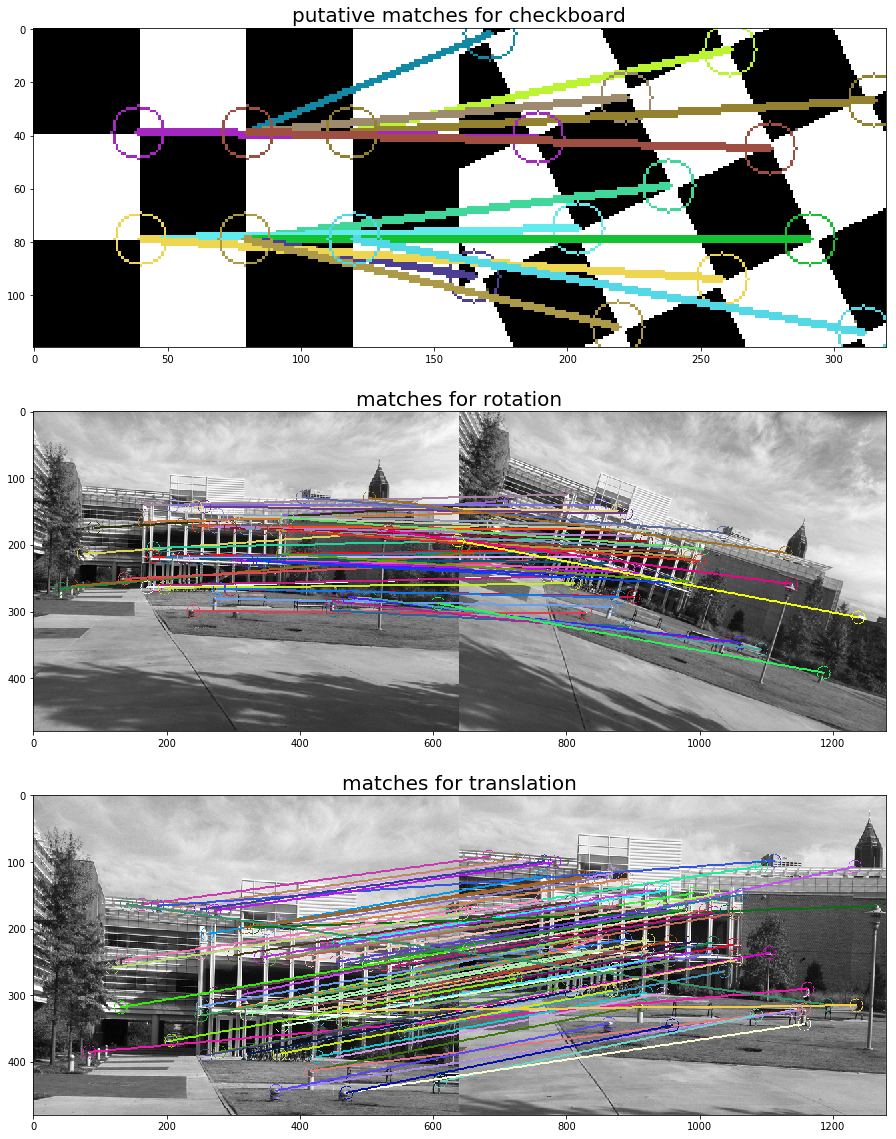

In [132]:
im,matches_c = findMatches(check,checkRot,kpCheck,kpCheckRot)
imA,matches_A = findMatches(simA,simB,kpSimA,kpSimB)
imB,matches_B = findMatches(transA,transB,kpTransA,kpTransB)
plt.figure(figsize=(20,20))
plt.subplot(3,1,1),plt.imshow(im),plt.title('putative matches for checkboard',fontsize=20)
plt.subplot(3,1,2),plt.imshow(imA),plt.title('matches for rotation',fontsize=20)
plt.subplot(3,1,3),plt.imshow(imB),plt.title('matches for translation',fontsize=20)
plt.show()

### RANSAC

In [150]:
def trans(im1,im2,tolerance):
    feat1,_ = features(im1)
    feat2,_ = features(im2)
    _,matches = findMatches(im1,im2,feat1,feat2)
    consSet = []
    for match in matches:
        tempConsSet=[]
        trainId = match[0].trainIdx
        queryId = match[0].queryIdx
        p1 = feat1[trainId].pt
        p2 = feat2[queryId].pt
        y1 = p1[1] 
        x1 = p1[0]
        y2 = p2[1]
        x2 = p2[0]
        dX = abs(x1-x2)
        dY = abs(y1-y2)
        for match2 in matches:
            trainId = match[0].trainIdx
            queryId = match[0].queryIdx
            p1 = feat1[trainId].pt
            p2 = feat2[queryId].pt
            diX = abs(p1[0]-p2[0])
            diY = abs(p1[1]-p2[1])
            if(abs(diX-dX)<tolerance and abs(diY-dY)<tolerance):
                tempConsSet.append((p1,p2))
        if(len(tempConsSet)>len(consSet)):
            consSet = tempConsSet
            bestMatch = (dX,dY)
    im = np.zeros((im1.shape[0],im1.shape[1]+im2.shape[1]))
    im[:,:im1.shape[1]]=im1
    im[:,im1.shape[1]:im.shape[1]]=im2
    im = im.astype('uint8')
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    for match in consSet:
        x1 = int(match[0][0])
        y1 = int(match[0][1])
        x2 = int(match[1][0]+im1.shape[1])
        y2 = int(match[1][1])
        color = tuple([random.randint(0,255) for i in range(3)])
        im = cv2.circle(im,(x1,y1),10,color)
        im = cv2.circle(im,(x2,y2),10,color)
        im = cv2.line(im,(x1,y1),(x2,y2),color,2)       
    M = np.array([[0,0,dX],[0,0,dY],[0,0,1]])
    return M,im

In [ ]:
M,im = trans(transA,transB,300)
print(M)

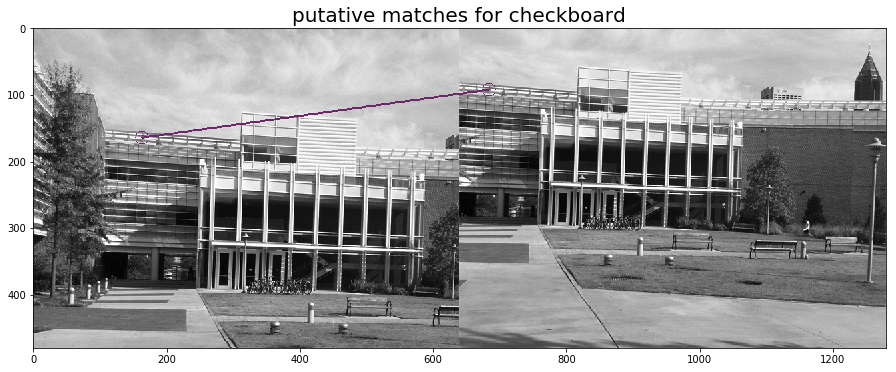

In [154]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1),plt.imshow(im),plt.title('putative matches for checkboard',fontsize=20)
plt.show()

In [156]:
print(M)

[[  0.   0. 151.]
 [  0.   0. 101.]
 [  0.   0.   1.]]


In [ ]:
def similarity(im1,im2):
    
    
    
    np.linalg.lstsq()
    return 